In [55]:
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

In [56]:
import yfinance as yf

start_date = '2019-03-01'
end_date = '2024-06-01'
symbol = 'ABBV'

data = yf.download(symbol, start=start_date, end=end_date)
data.to_csv('AbbVie_data.csv')

[*********************100%%**********************]  1 of 1 completed


In [57]:
df = pd.read_csv('AbbVie_data.csv')
df1 = df.reset_index()['Open']

In [58]:
print(df1)

0        79.769997
1        80.400002
2        79.379997
3        79.129997
4        77.769997
           ...    
1318    158.360001
1319    156.350006
1320    154.889999
1321    154.649994
1322    156.649994
Name: Open, Length: 1323, dtype: float64


In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [60]:
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [61]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [62]:
X_train

array([[0.13665012, 0.14194473, 0.13337254, ..., 0.03891084, 0.04193631,
        0.03773428],
       [0.14194473, 0.13337254, 0.13127152, ..., 0.04193631, 0.03773428,
        0.03580131],
       [0.13337254, 0.13127152, 0.11984199, ..., 0.03773428, 0.03580131,
        0.03319607],
       ...,
       [0.69955459, 0.70165561, 0.70098326, ..., 0.67089669, 0.71602662,
        0.71031178],
       [0.70165561, 0.70098326, 0.71762328, ..., 0.71602662, 0.71031178,
        0.73535587],
       [0.70098326, 0.71762328, 0.72451468, ..., 0.71031178, 0.73535587,
        0.75846706]])

In [63]:
model=RandomForestRegressor()

In [64]:
grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': np.arange(5, 25, 5),
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': np.arange(1, 3, 5, dtype=int),
    'bootstrap': [True, False],
    'random_state': [0, 20, 40, 60]
}

rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(X_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=0; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=0; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50, random_state=0; total time=   1.0s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0; total time=   1.2s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0; total time=   1.3s
[CV] END bootstrap=False, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50, random_state=0; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=20; total time=   1.5s
[CV] END bootst

In [65]:
best_parameters

{'random_state': 40,
 'n_estimators': 50,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': False}

In [66]:
model = RandomForestRegressor(n_estimators=best_parameters['n_estimators'], random_state=best_parameters['random_state'], min_samples_split=best_parameters['min_samples_split'],
                              min_samples_leaf=best_parameters['min_samples_leaf'], max_depth=best_parameters['max_depth'], bootstrap=best_parameters['bootstrap'])
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=10, min_samples_split=7,
                      n_estimators=50, random_state=40)

In [67]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [68]:
# Chuẩn hóa dữ liệu dự đoán
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [69]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))


In [70]:
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, y_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 4))
print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred) * 100, 4)}%")

Mean Squared Error: 138.9668
Root Mean Squared Error: 11.7884
Mean Absolute Percentage Error: 4.745%


In [71]:
# Dự báo cho 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
i = 0
while i < 60:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

lst_output = np.array(lst_output).reshape(-1, 1)


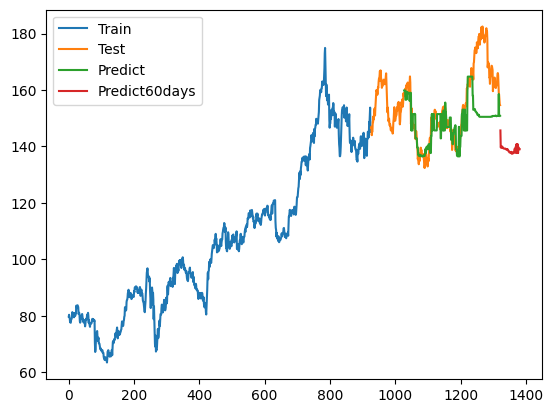

In [72]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict60days'])
plt.show()